In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets
from torchvision import transforms as tr
from torchvision.io import read_image
from torchvision import models
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_folder = "./RGBaHa(26-03-23)"
images_folder = "RGBaHa"
table_file = "data.csv"
types_file = "types.csv"

In [4]:
target_column = "dbh"

In [5]:
class TreeDataset(Dataset):
    def __init__(self, imgs_path, table_path, types_path):
        super().__init__()
        
        self.types = pd.read_csv(types_path, index_col=0)
        self.table = pd.read_csv(table_path, index_col=0, converters={"latin": lambda x: self.types.loc[x].type if x != "NA" else np.nan}).dropna()
        self.label_map = {label: i for i, label in enumerate(self.table.latin.unique())}
        self.table = self.table.replace({"latin": self.label_map})
        
        self.max_h, self.max_w = 0, 0
        self.channel_mean, self.channel_std = 0, 0
        self.depth_max = 0
        images = []
        # resizer = tr.Resize((224, 224), antialias=True)
        for tree_id in self.table.treeID:
            file_path = os.path.join(imgs_path, f"treeID_{tree_id}.tiff")
            img_rgb = skimage.io.imread(file_path)[:, :, [0, 1, 2]].transpose(2, 0, 1)[None, :, :, :]
            self.max_h = max(self.max_h, img_rgb.shape[2])
            self.max_w = max(self.max_w, img_rgb.shape[3])
            # resized_img = resizer(torch.from_numpy(img_rgb))
            # images.append(resized_img)
            images.append(torch.from_numpy(img_rgb))
        
        padded_images = []
        rng = np.random.default_rng()
        for image in images:
            img_h, img_w = image.shape[2:]
            h_pos = rng.integers(0, self.max_h - img_h + 1)
            w_pos = rng.integers(0, self.max_w - img_w + 1)
            padded = torch.zeros(1, 3, self.max_h, self.max_w)
            padded[:, :, h_pos: h_pos+img_h, w_pos: w_pos+img_w] = image
            padded_images.append(padded)
            
            image /= 255.
            self.channel_mean += image.mean(dim=(0, 2, 3))
            self.channel_std += image.std(dim=(0, 2, 3))

        self.images = torch.cat(padded_images)
        
    def __getitem__(self, index):
        x = self.images[index].type(torch.FloatTensor)
        y_clf = torch.tensor(self.table.iloc[index].loc[target_column])
        return x, y_clf
    
    def __len__(self):
        return len(self.table)

In [33]:
class TreeDatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y_regr = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x.type(torch.float), y_regr.type(torch.float)

    def __len__(self):
        return len(self.subset)

In [34]:
data = TreeDataset(os.path.join(data_folder, images_folder), 
                   os.path.join(data_folder, table_file), 
                   os.path.join(data_folder, types_file))

In [35]:
train, val, test = random_split(data, [0.70, 0.20, 0.10])

In [36]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [37]:
augment_transform = tr.Compose([
    tr.Normalize(data.channel_mean, data.channel_std),
    # tr.RandomApply([AddGaussianNoise()]),
    tr.RandomHorizontalFlip(),
    tr.RandomVerticalFlip(),
    tr.RandomAffine(degrees=180),#, translate=(0.3, 0.4), scale=(0.4, 0.8)),
    # tr.RandomAdjustSharpness(0.5),
    # tr.RandomAutocontrast(),
    # tr.Resize((490, 392), antialias=True),
])

prepare_transform = tr.Compose([
    tr.Normalize(data.channel_mean, data.channel_std),
    # tr.Resize((490, 392), antialias=True)
])

In [38]:
train_dataset = TreeDatasetFromSubset(train, augment_transform)
val_dataset = TreeDatasetFromSubset(val, prepare_transform)

Targets:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(14.6423)


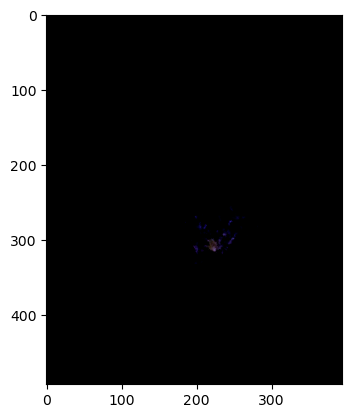

In [39]:
print("Targets:")
idx = np.random.randint(0, 100)
print(train_dataset[idx][1])
plt.imshow(train_dataset[idx][0].movedim(0, -1))
plt.show()

In [40]:
def make_weights_for_balanced_classes(data, indices=None):
    n_images = len(data.table)
    count_per_class = np.bincount(data.table.latin, minlength=len(data.table.latin.unique()))
    weight_per_class = (float(n_images) / count_per_class)
    weights = weight_per_class[data.table.latin]
    if indices:
        weights = weights[indices]
    return torch.tensor(weights)

In [41]:
BATCH_SIZE = 32

train_weights = make_weights_for_balanced_classes(train.dataset, train.indices)
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    drop_last=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

all_loader = DataLoader(
    dataset=TreeDatasetFromSubset(data, prepare_transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [42]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        stride = (2, 2) if in_channels != out_channels else (1, 1)

        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, (1, 1), stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), stride, padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, (3, 3), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = self.shortcut(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)

        return x + residual


class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(out_channels, out_channels)
        )
        
    def forward(self, x):
        x = self.blocks(x)
        return x

In [43]:
class ResNet18(nn.Module):
    def __init__(self, out_channels=32, layer_num=3, fc_regr_hidden=128, in_channels=3, classes_num=len(data.label_map)):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), padding=(1, 1), bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d((2, 2))
        self.layers = nn.Sequential(
            ResNetLayer(out_channels, out_channels),
            *[ResNetLayer(2**i * out_channels, 2**(i+1) * out_channels) for i in range(layer_num - 1)],
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        # predicting main characteristics
        self.fc_regr = nn.Sequential(
            nn.Linear(2**(layer_num - 1) * out_channels, fc_regr_hidden),
            nn.BatchNorm1d(fc_regr_hidden),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(fc_regr_hidden, 1),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        x = self.layers(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x_regr = self.fc_regr(x)
        return x_regr.squeeze()

In [44]:
import IPython


def train_loop(model, dataloader, loss_regr_fn, optimizer, step=0.05, history_loss=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_loss = []
    percentage = 0
    
    for batch, (X, y_regr) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        torch.cuda.empty_cache()
        gc.collect()
        
        X = X.to(device)
        y_regr = y_regr.to(device)
        pred_regr = model(X)
        loss = loss_regr_fn(pred_regr, y_regr)
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch / (num_batches - 1) >= percentage:
            percentage = int(batch / (num_batches - 1) / step) * step
            out.update(f'[{int(percentage * size)}/{size}] Batch RMSE Loss: {np.sqrt(loss.item()):>8f}')
    
    total_loss = np.mean(np.sqrt(train_loss))
    if history_loss is not None:
        history_loss.append(total_loss)
    return {'train_loss': total_loss}


def test_loop(model, dataloader, loss_regr_fn, history_loss=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    val_loss = []

    with torch.no_grad():
        for batch, (X, y_regr) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
            torch.cuda.empty_cache()
            gc.collect()
        
            X = X.to(device)
            y_regr = y_regr.to(device)
            pred_regr = model(X)
            loss = loss_regr_fn(pred_regr, y_regr)
            val_loss.append(loss.item())
    
        total_loss = np.mean(np.sqrt(val_loss))
        print(f"Validation RMSE Loss: {total_loss:>8f} \n")

    if history_loss is not None:
        history_loss.append(total_loss)
    return {'val_loss': total_loss}

In [45]:
def plot_learning_process(train_loss, val_loss, title):
    
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = plt.subplot(121)
    ax1.plot(np.arange(0, len(train_loss)) + 1, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel(title.split()[0])
    ax1.set_title(title)
    
    fig.tight_layout()
    plt.show()

In [46]:
loss_regr = nn.MSELoss()
epochs = 50

models_results = []
for chan in tqdm([8]):
    for layer_n in tqdm([3]):
        for fc_regr_hidden in tqdm([512]):
            net = ResNet18(out_channels=chan, layer_num=layer_n, fc_regr_hidden=fc_regr_hidden).to(device)
            optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, min_lr=1e-7)

            train_loss = []
            val_loss = []

            models_results.append({"first_out_channel": chan, "layer_num": layer_n, "fc_regr_hidden": fc_regr_hidden})
            for epoch in range(epochs):
                print(f"Epoch {epoch+1}")
                print("-------------------------------")
                train_loop(net, train_dataloader, loss_regr, optimizer, history_loss=train_loss)
                test_loop(net, val_dataloader, loss_regr, history_loss=val_loss)
                scheduler.step(train_loss[-1])
            
            models_results[-1][f"train_{target_column}_RMSE"] = train_loss
            models_results[-1][f"val_{target_column}_RMSE"] = val_loss

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1
-------------------------------


'[318/318] Batch RMSE Loss: 40.171419'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 42.422846 

Epoch 2
-------------------------------


'[318/318] Batch RMSE Loss: 40.274930'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 41.622909 

Epoch 3
-------------------------------


'[318/318] Batch RMSE Loss: 37.990587'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 40.695599 

Epoch 4
-------------------------------


'[318/318] Batch RMSE Loss: 39.108117'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 39.818098 

Epoch 5
-------------------------------


'[318/318] Batch RMSE Loss: 40.482766'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 39.050591 

Epoch 6
-------------------------------


'[318/318] Batch RMSE Loss: 44.892184'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 38.270646 

Epoch 7
-------------------------------


'[318/318] Batch RMSE Loss: 39.929260'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 37.458620 

Epoch 8
-------------------------------


'[318/318] Batch RMSE Loss: 34.705923'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 36.557624 

Epoch 9
-------------------------------


'[318/318] Batch RMSE Loss: 37.584836'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 35.622772 

Epoch 10
-------------------------------


'[318/318] Batch RMSE Loss: 30.201472'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 35.069582 

Epoch 11
-------------------------------


'[318/318] Batch RMSE Loss: 31.030693'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 33.923611 

Epoch 12
-------------------------------


'[318/318] Batch RMSE Loss: 29.673652'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 33.033256 

Epoch 13
-------------------------------


'[318/318] Batch RMSE Loss: 32.693579'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 32.691828 

Epoch 14
-------------------------------


'[318/318] Batch RMSE Loss: 25.259998'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 31.757985 

Epoch 15
-------------------------------


'[318/318] Batch RMSE Loss: 30.181191'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 30.992628 

Epoch 16
-------------------------------


'[318/318] Batch RMSE Loss: 26.169886'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 30.208942 

Epoch 17
-------------------------------


'[318/318] Batch RMSE Loss: 28.991442'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 29.087268 

Epoch 18
-------------------------------


'[318/318] Batch RMSE Loss: 26.473338'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 27.964605 

Epoch 19
-------------------------------


'[318/318] Batch RMSE Loss: 21.102980'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 27.618332 

Epoch 20
-------------------------------


'[318/318] Batch RMSE Loss: 22.270117'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 26.674474 

Epoch 21
-------------------------------


'[318/318] Batch RMSE Loss: 26.274626'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 25.890012 

Epoch 22
-------------------------------


'[318/318] Batch RMSE Loss: 22.783141'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 24.935416 

Epoch 23
-------------------------------


'[318/318] Batch RMSE Loss: 27.672204'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 24.485182 

Epoch 24
-------------------------------


'[318/318] Batch RMSE Loss: 17.635524'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 23.794939 

Epoch 25
-------------------------------


'[318/318] Batch RMSE Loss: 23.528583'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 23.787880 

Epoch 26
-------------------------------


'[318/318] Batch RMSE Loss: 15.180501'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 22.901795 

Epoch 27
-------------------------------


'[318/318] Batch RMSE Loss: 19.126478'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 22.386267 

Epoch 28
-------------------------------


'[318/318] Batch RMSE Loss: 20.480889'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 22.128208 

Epoch 29
-------------------------------


'[318/318] Batch RMSE Loss: 15.857482'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 20.974742 

Epoch 30
-------------------------------


'[318/318] Batch RMSE Loss: 21.958585'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 21.585496 

Epoch 31
-------------------------------


'[318/318] Batch RMSE Loss: 15.847899'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 21.245903 

Epoch 32
-------------------------------


'[318/318] Batch RMSE Loss: 11.927863'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 20.420033 

Epoch 33
-------------------------------


'[318/318] Batch RMSE Loss: 18.207384'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 19.853014 

Epoch 34
-------------------------------


'[318/318] Batch RMSE Loss: 13.988563'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 19.273753 

Epoch 35
-------------------------------


'[318/318] Batch RMSE Loss: 16.097151'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 19.101503 

Epoch 36
-------------------------------


'[318/318] Batch RMSE Loss: 14.123133'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 18.743568 

Epoch 37
-------------------------------


'[318/318] Batch RMSE Loss: 18.543281'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 18.677653 

Epoch 38
-------------------------------


'[318/318] Batch RMSE Loss: 14.049359'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 18.611594 

Epoch 39
-------------------------------


'[318/318] Batch RMSE Loss: 15.023181'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 18.724106 

Epoch 40
-------------------------------


'[318/318] Batch RMSE Loss: 15.832379'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 18.530842 

Epoch 41
-------------------------------


'[318/318] Batch RMSE Loss: 13.796449'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 18.142185 

Epoch 42
-------------------------------


'[318/318] Batch RMSE Loss: 12.649372'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 17.787914 

Epoch 43
-------------------------------


'[318/318] Batch RMSE Loss: 11.716504'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 17.942785 

Epoch 44
-------------------------------


'[318/318] Batch RMSE Loss: 10.127196'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 18.060716 

Epoch 45
-------------------------------


'[318/318] Batch RMSE Loss: 10.188686'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 16.703887 

Epoch 46
-------------------------------


'[318/318] Batch RMSE Loss: 10.640142'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 17.438386 

Epoch 47
-------------------------------


'[318/318] Batch RMSE Loss: 11.594829'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 17.847039 

Epoch 48
-------------------------------


'[318/318] Batch RMSE Loss: 12.558498'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 18.054038 

Epoch 49
-------------------------------


'[318/318] Batch RMSE Loss: 13.013400'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 18.918192 

Epoch 50
-------------------------------


'[318/318] Batch RMSE Loss: 17.792197'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 19.418007 



In [47]:
results_df = pd.DataFrame(models_results)

In [48]:
# expanded_df = results_df.set_index(["first_out_channel"]).apply(pd.Series.explode).reset_index()

# expanded_df.index.name = "Epoch"
# expanded_df.index = expanded_df.index + 1
# expanded_df.dropna()

first_out_channel      8
layer_num              3
fc_regr_hidden       512
Name: 0, dtype: object


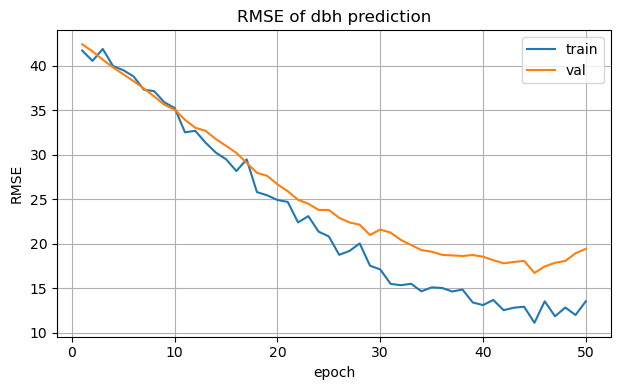

In [50]:
for i in range(len(results_df)):
    row = results_df.iloc[i]
    print(row[:3])
    plot_learning_process(row[f"train_{target_column}_RMSE"], row[f"val_{target_column}_RMSE"], f"RMSE of {target_column} prediction")

In [51]:
test_dataset = TreeDatasetFromSubset(test, prepare_transform)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [33]:
PATH = f"{target_column}_prediction_model.pt"
assert not os.path.exists(PATH), "There is a checkpoint already! Remove this assert to override"
test_results = test_loop(net, test_dataloader, loss_clf)
torch.save({
    'epoch': epochs,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': test_results["val_loss"],
    'acc': test_results["val_acc"]
},
    PATH)

AssertionError: There is a checkpoint already! Remove this assert to override

In [ ]:
model = ResNet18(out_channels=8, layer_num=3, fc_clf_hidden=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
acc = checkpoint['acc']

model.eval()